Зависимости

In [37]:
import numpy as np
import pandas as pd

import pickle
import sklearn

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error

from sklearn.pipeline import Pipeline

In [2]:
train_df = pd.read_csv('./models/data/train.csv')
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [3]:
encoder = OrdinalEncoder()
cat = [col for col in train_df.columns if train_df[col].dtype == 'object']
train_df[cat] = encoder.fit_transform(train_df[cat])
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,0.0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,1.0,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2.0,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,3.0,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,4.0,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


### Проверка доли недостающих данных в каждом столбце

In [4]:
missing = train_df.isnull().sum() * 100 / len(train_df)
missing_df = pd.DataFrame({'col': train_df.columns, 'missing_values': missing})
missing_df = missing_df[missing_df.missing_values != 0]
missing_df.sort_values('missing_values', inplace=True, ascending=False)
missing_df.head()

,col,missing_values
hospital_beds_raion,hospital_beds_raion,47.392603
build_year,build_year,44.649011
state,state,44.498047
cafe_sum_500_max_price_avg,cafe_sum_500_max_price_avg,43.585704
cafe_sum_500_min_price_avg,cafe_sum_500_min_price_avg,43.585704


### Удалим все столбцы, где пропусков больше 40%

In [5]:
cols_to_remove = missing_df[missing_df.missing_values > 40].col.to_list()
train_df.drop(cols_to_remove, inplace=True, axis=1)

In [6]:
train_df.drop('timestamp', inplace=True, axis=1)

imputer = SimpleImputer(strategy='most_frequent')
itrain_df = pd.DataFrame(imputer.fit_transform(train_df))
itrain_df.columns = train_df.columns

### Посмотрим как сильно переменные влияют на целевое значение 

In [7]:
X = itrain_df.drop('price_doc', axis=1)
y = itrain_df['price_doc']

model = XGBRegressor(n_estimators=200, max_depth=13, random_state=987, eta=0.01)
model.fit(X, y)

feature_importanse_df = pd.DataFrame({'col': X.columns, 'importanse': model.feature_importances_})
feature_importanse_df.sort_values('importanse', inplace=True, ascending=False)
feature_importanse_df.head()

,col,importanse
252,cafe_count_3000_price_2500,0.203972
275,cafe_count_5000_price_2500,0.074721
259,sport_count_3000,0.036182
221,cafe_count_2000,0.035168
264,office_sqm_5000,0.030004


### Оставляю только те переменные, которые влияют на целевую приманную больше чем на 16%

In [8]:
cols = feature_importanse_df[feature_importanse_df.importanse > 0.016]
train = itrain_df[cols.col.to_list()]
train['price_doc'] = itrain_df.price_doc.values
train.head()

/var/folders/_m/7mp1j5t54rz8yv1l47v5m_tm0000gn/T/ipykernel_6521/2961518299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['price_doc'] = itrain_df.price_doc.values


,cafe_count_3000_price_2500,cafe_count_5000_price_2500,sport_count_3000,cafe_count_2000,office_sqm_5000,cafe_count_1500_price_high,full_sq,cafe_count_3000,culture_objects_top_25,build_count_monolith,female_f,price_doc
0,3.0,9.0,21.0,36.0,807385.0,0.0,43.0,68.0,0.0,2.0,45729.0,5850000.0
1,2.0,15.0,19.0,21.0,2690465.0,0.0,34.0,30.0,1.0,4.0,42084.0,6000000.0
2,3.0,10.0,20.0,24.0,1478160.0,0.0,43.0,41.0,0.0,4.0,55906.0,5700000.0
3,3.0,11.0,18.0,25.0,244166.0,0.0,89.0,32.0,0.0,50.0,11327.0,13100000.0
4,149.0,319.0,77.0,483.0,8404624.0,1.0,77.0,1068.0,0.0,16.0,14657.0,16331452.0


### Посмотрим как признаки коррелируют между собой

<AxesSubplot:>

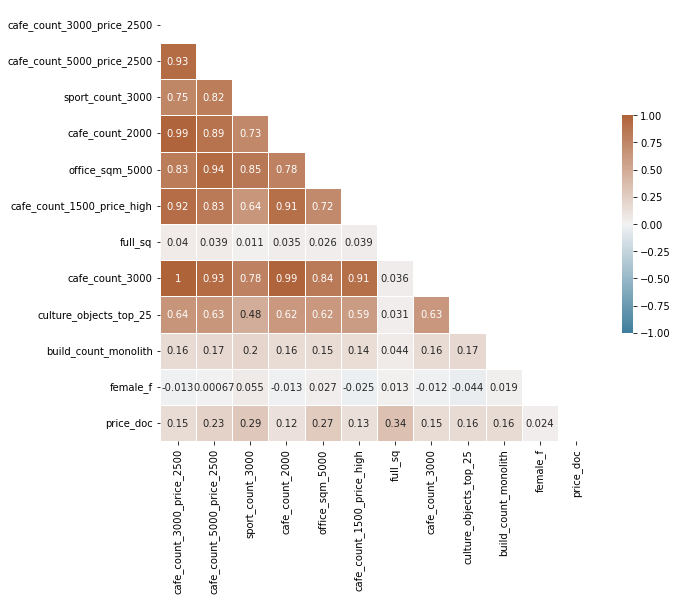

In [9]:
fig = plt.figure(figsize=(10,8))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Высокая корреляция между атрибутами, относящимися к территории, в которой расположен объект, за исключением «ttk_km».
### Оценим переменные для удаления на основе корреляции между ними и «price_doc».

In [10]:
cols_to_remove = ['cafe_count_3000_price_2500',
 'cafe_count_5000_price_2500',
 'cafe_count_2000',
 'office_sqm_5000',
 'cafe_count_1500_price_high']

train2 = train.drop(cols_to_remove, axis=1)


<AxesSubplot:>

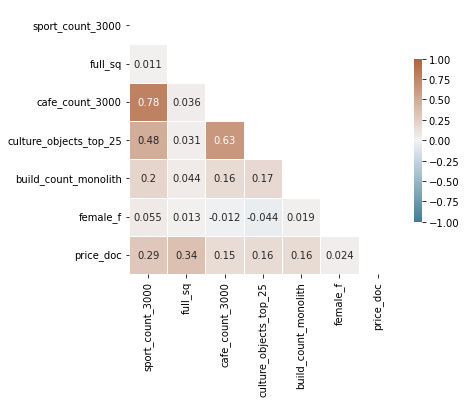

In [11]:
fig = plt.figure(figsize=(6,6))
corr = train2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [12]:
cols = ['id', 'full_sq', 'culture_objects_top_25', 'female_f', 'build_count_monolith', 'cafe_count_3000', 'sport_count_3000', 'price_doc']
df_train = pd.read_csv("./models/data/train.csv", usecols=cols)
cols.remove('price_doc')
df_test = pd.read_csv("./models/data/test.csv", usecols=cols)

**full_sq** общая площадь в квадратных метрах, включая лоджии, балконы и другие нежилые помещения.

**culture_objects_top_25** Наличие ключевых объектов культурного наследия (значимых объектов для уровня субъектов РФ, города)

**Female_f** Женское население

**build_count_monolith** Доля монолитных зданий

**cafe_count_3000** Количество кафе или ресторанов в зоне 1500 метров

**sport_count_3000** Количество спортивных сооружений в 3000-метровой зоне

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      30471 non-null  int64  
 1   full_sq                 30471 non-null  int64  
 2   culture_objects_top_25  30471 non-null  object 
 3   female_f                30471 non-null  int64  
 4   build_count_monolith    25480 non-null  float64
 5   cafe_count_3000         30471 non-null  int64  
 6   sport_count_3000        30471 non-null  int64  
 7   price_doc               30471 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 1.9+ MB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7662 non-null   int64  
 1   full_sq                 7662 non-null   float64
 2   culture_objects_top_25  7662 non-null   object 
 3   female_f                7662 non-null   int64  
 4   build_count_monolith    6444 non-null   float64
 5   cafe_count_3000         7662 non-null   int64  
 6   sport_count_3000        7662 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 419.1+ KB


In [15]:
df_train['build_count_monolith'].value_counts()

0.0      2812
2.0      2738
4.0      2297
3.0      2021
9.0      1820
7.0      1610
5.0      1412
8.0      1244
1.0      1103
16.0      805
12.0      755
50.0      679
25.0      678
6.0       606
13.0      592
17.0      508
18.0      477
14.0      465
116.0     451
11.0      342
49.0      262
24.0      255
38.0      241
33.0      190
21.0      184
19.0      173
58.0      164
34.0      136
10.0      105
27.0      103
47.0      100
48.0       90
127.0      62
Name: build_count_monolith, dtype: int64

In [16]:
df_train['build_count_monolith'].replace(np.NaN, 1.0, inplace=True)
df_test['build_count_monolith'].replace(np.NaN, 1.0, inplace=True)

In [17]:
df_train['culture_objects_top_25'].unique()

array(['no', 'yes'], dtype=object)

In [18]:
df_train['bin_culture_objects_top_25'] = np.where(df_train['culture_objects_top_25'] == 'yes', 1, 0)
df_train.drop('culture_objects_top_25', axis=1, inplace=True)
df_test['bin_culture_objects_top_25'] = np.where(df_test['culture_objects_top_25'] == 'yes', 1, 0)
df_test.drop('culture_objects_top_25', axis=1, inplace=True)

### Создадим модели и обучаем их так же сравним результаты

In [19]:
X = df_train.drop(['id','price_doc'], axis=1)
y = np.log(df_train.price_doc)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=9)

lasso = Lasso()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print('RMSLE: ', mean_squared_log_error(y_test,y_pred,squared=False))

RMSLE:  0.03451016417676712


In [20]:
X = df_train.drop(['id','price_doc'], axis=1)
y = np.log(df_train.price_doc)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=9)
xgb = XGBRegressor(n_estimators=286, max_depth=9, random_state=9, eta=.03)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print('RMSLE: ', mean_squared_log_error(y_test,y_pred,squared=False))

RMSLE:  0.029829974247683022


In [21]:
# pickle.dump(xgb, open('./models/test_model.dump', 'wb'))
# xgb_model_loaded = pickle.load(open('model', "rb"))

### Pipeline

In [26]:
# Preprocessing data
from sklearn.compose import ColumnTransformer

ordinal_encoder = OrdinalEncoder()
imputer = SimpleImputer(strategy='most_frequent')

x_copy = x_train.copy()
 

preprocessor = ColumnTransformer(
    transformers=[
        ('all', imputer, x_copy.columns.to_list()),
        ('cat', ordinal_encoder, [col for col in x_copy.columns if x_copy[col].dtype == 'object' ])
    ])


xgb = XGBRegressor(n_estimators=286, max_depth=9, random_state=9, eta=.03)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

clf.fit(x_copy, y_train)
test_preds = clf.predict(x_test)

In [27]:
pickle.dump(clf, open('./models/model.dump', 'wb'))

In [43]:
print('np ', np.__version__)
print('sklearn ', sklearn.__version__)


np  1.21.5
sklearn  1.0.2
